**Import Libraries**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

**Load Dataset**
> Here, I am loading the pre-processed data from the previous notebook and just the two columns which I require for Sentiment Analysis.
* *cleaned_reviews*
* *sentiment*


In [0]:
df = pd.read_csv("/content/drive/My Drive/Drug Reviews Dataset/DrugReviewsSentimentAnalysis.csv")

Checking for NULL values

In [0]:
df.isnull().sum()

Unnamed: 0         0
cleaned_reviews    6
sentiment          0
dtype: int64

There are 20 NULL values in the *cleaned_reviews* column.

Dropping NULL values

In [0]:
df = df.dropna()
df = df.reset_index(drop=True)

**Create Tokens**

Now I am gonna take the *cleaned_reviews* column and separate each sentence into a list of tokens (or words).

In [0]:
reviews = df['cleaned_reviews'].values

In [0]:
review_tokens = [row.split() for row in reviews]

In [0]:
vocab = list()
for token in review_tokens:
  vocab.extend(token)

*vocab* contains all bunch of words including duplicates. Using that I will be showing a world cloud of the text data.

**Word Cloud**

In [0]:
wordcloud_text = " ".join(vocab)

In [0]:
wc = WordCloud(width=500, height=500, background_color="white", max_words=500, max_font_size=100).generate(wordcloud_text)

The main thing about a word cloud is that the size of each word represents the frequency (or importance) of that word in the text data.

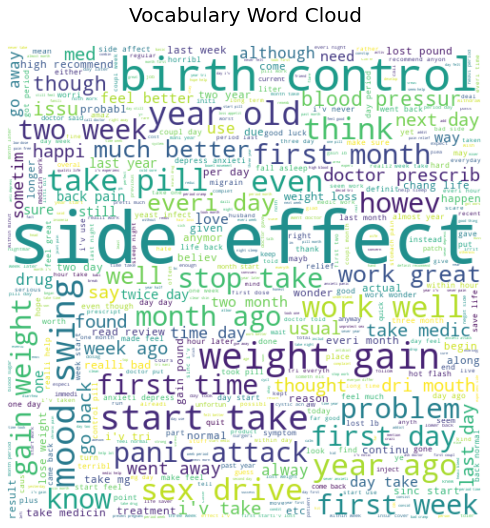

In [0]:
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation='bilinear')
plt.suptitle("Vocabulary Word Cloud", fontsize=20)
plt.axis('off')
plt.tight_layout(pad=5)
plt.show()

So the most frequent words in the text data have large font in the word cloud.

**Build Vocabulary**

Fetching unique words from *vocab* to build a proper vocabulary

In [0]:
vocabulary = list(set(vocab))
len_vocab = len(vocabulary)
print("Length of vocabulary: ",len_vocab)

Length of vocabulary:  39197


There are a total of 39,197 words in the vocabulary.

**Label Encoding**
> What *LabelEncoder* does is it gives a specific label (integer) to each word in our vocabulary. 

In [0]:
encoder = LabelEncoder()
encoder.fit(vocabulary)

LabelEncoder()

Creating a label encoded token vector of all the reviews

In [0]:
token_vect = list()

max_tokens = 0
for row in review_tokens:
  encoded = encoder.transform(row).tolist()
  size = len(encoded)
  if size > max_tokens:
    max_tokens = size
  token_vect.append(encoded)

print(max_tokens)

971


Now, each row in the token vector will be of different lengths. Therefore, padding needs to be done to the length (*max_tokens*=971) of the biggest row in the token vector, so that the token vector is of uniform shape.

In [0]:
padded = []

for row in token_vect:
  r = np.pad(row, (0, max_tokens-len(row)), 'constant')
  padded.append(r)

final_token_vect = np.array(padded)
print(final_token_vect.shape)

(212692, 971)


All the rows in the token vector have been padded to the same length.

**Target Label Encoding**

The target values are *positive* and *negative*.
I will be using LabelEncoder to assign binary values to them.
* 0 - negative
* 1 - positive

In [0]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['sentiment'].values)

labels = labels.reshape(-1,1)
print(labels.shape)

(212692, 1)


**Split Data**

First, I will split the data into two sets:
* Feed Data (to feed to the model)
* Test Data (to predict the targets after training the model)

Second, I will split the feed data into two sets:
* Train Data
* Validation Data

In [0]:
xfeed, xtest, yfeed, ytest = train_test_split(final_token_vect, labels, test_size=0.25)
xtrain, xval, ytrain, yval = train_test_split(xfeed, yfeed, test_size=0.4)
print("Train data: ",xtrain.shape)
print("Validation data: ",xval.shape)
print("Test data: ",xtest.shape)

Train data:  (95711, 971)
Validation data:  (63808, 971)
Test data:  (53173, 971)


**Create Tensor Datasets**

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val_dataset = tf.data.Dataset.from_tensor_slices((xval, yval))

Creating batches of the data for batch-wise training

In [0]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_data = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_data = val_dataset.batch(BATCH_SIZE)

**Build Model**
> I will be using a Keras Sequential Model. The layers are:
* Embedding layer to learn the word embeddings
* GlobalAveragePooling1D layer to flatten the matrix 
* Input layer (200 nodes)
* Hidden layer (300 nodes)
* Output layer (1 node)

In [0]:
embedding_dim = 140

model = models.Sequential()

model.add(keras.layers.Embedding(len_vocab, embedding_dim))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(0.0001),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

Printing summary of the above defined model

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 140)         5487580   
_________________________________________________________________
global_average_pooling1d (Gl (None, 140)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               28200     
_________________________________________________________________
dense_1 (Dense)              (None, 300)               60300     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301       
Total params: 5,576,381
Trainable params: 5,576,381
Non-trainable params: 0
_________________________________________________________________


**Train Model**

In [0]:
model.fit(train_data, epochs=15, validation_data=val_data, verbose=2)

Epoch 1/15
1496/1496 - 81s - loss: 0.6101 - accuracy: 0.7032 - val_loss: 0.6083 - val_accuracy: 0.6995
Epoch 2/15
1496/1496 - 86s - loss: 0.5750 - accuracy: 0.7108 - val_loss: 0.4907 - val_accuracy: 0.7478
Epoch 3/15
1496/1496 - 82s - loss: 0.4377 - accuracy: 0.8017 - val_loss: 0.4235 - val_accuracy: 0.8081
Epoch 4/15
1496/1496 - 85s - loss: 0.4072 - accuracy: 0.8187 - val_loss: 0.4118 - val_accuracy: 0.8144
Epoch 5/15
1496/1496 - 82s - loss: 0.3941 - accuracy: 0.8258 - val_loss: 0.4050 - val_accuracy: 0.8211
Epoch 6/15
1496/1496 - 85s - loss: 0.3838 - accuracy: 0.8314 - val_loss: 0.4003 - val_accuracy: 0.8217
Epoch 7/15
1496/1496 - 82s - loss: 0.3759 - accuracy: 0.8361 - val_loss: 0.3977 - val_accuracy: 0.8230
Epoch 8/15
1496/1496 - 85s - loss: 0.3692 - accuracy: 0.8401 - val_loss: 0.3948 - val_accuracy: 0.8258
Epoch 9/15
1496/1496 - 87s - loss: 0.3631 - accuracy: 0.8435 - val_loss: 0.4000 - val_accuracy: 0.8223
Epoch 10/15
1496/1496 - 85s - loss: 0.3585 - accuracy: 0.8463 - val_loss:

**Plot characteristics**

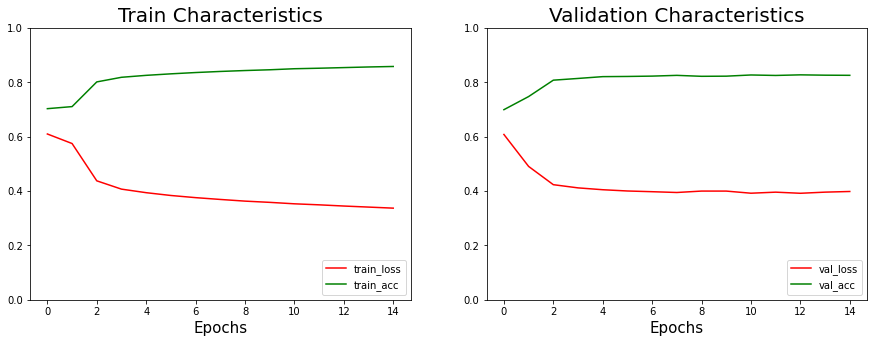

In [0]:
epoch = model.history.epoch
history = model.history.history

fig = plt.figure(figsize=(15,5))

plt.subplot(121)
plt.ylim([0.0, 1.0])
plt.plot(epoch, history['loss'],'r', epoch, history['accuracy'], 'g')
plt.title('Train Characteristics', fontsize=20)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('', fontsize=15)
plt.legend(['train_loss','train_acc'], loc='lower right')

plt.subplot(122)
plt.ylim([0.0, 1.0])
plt.plot(epoch, history['val_loss'], 'r', epoch, history['val_accuracy'], 'g')
plt.title('Validation Characteristics', fontsize=20)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('', fontsize=15)
plt.legend(['val_loss','val_acc'], loc='lower right')

plt.show()

**Predict on Test Data**

In [0]:
pred = model.predict(xtest)
ypred = np.round(pred)
print('Accuracy: '+str(np.round(accuracy_score(ytest, ypred)*100, 2))+'%')

Accuracy: 82.67%
